Nick Yurashku

IST 769 Final

## Introduction  

This project analyses **CAISO Congestion Revenue Rights (CRRs)** for the 2025 auction year.

We ingest daily Day-Ahead LMP ZIPs and monthly CRR-Clearing CSVs from the CAISO portal, transform them
with PySpark, persist cleaned & enriched tables to Cassandra, and finish with
exploratory data analysis (EDA) in this notebook.  

Key questions:

* *Did the auction clearing price accurately predict realised congestion?*  
* *Which sink PNodes consistently captured positive congestion?*  
* *How did the most profitable paths evolve through time?*  


# Project layout recap

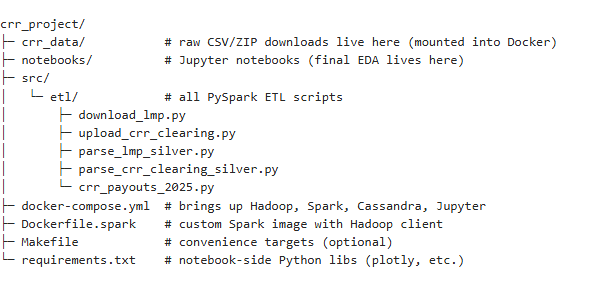

# How to clone the project

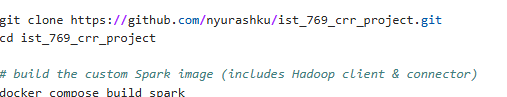

## Project road-map (ETL → EDA)  

| Step | Description | Tooling |
|------|-------------|---------|
| **1 – Ingest** | Download daily LMP ZIPs (`PRC_LMP`) and manual CRR CSVs → load to HDFS *raw* zone | `download_lmp.py`, `upload_crr_clearing.py` (Python + HDFS CLI) |
| **2 – Silver** | Unzip / parse, cast numerics, de-duplicate re-runs, convert to UTC | `parse_lmp_silver.py`, `parse_crr_clearing_silver.py` (PySpark) |
| **3 – Enrich** | Join LMPs to CRR paths → `realized_cong = lmp_sink − lmp_source` | `crr_payouts_2025.py` (PySpark) |
| **4 – Persist** | Write `crr_payouts`, `crr_auctions`, `lmp_daily` to Cassandra keyspace **caiso** | Spark-Cassandra conn
ector |
| **5 – EDA** | • Box-plot: Auction $/MW vs Realised co, • Heat-map: Avg congestion by PNode, • Time-series: Top-5 paths payout | Jupyter + Plotly | Plotly |


# Start the Stack

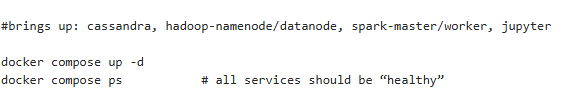y”

## Run-book (how to reproduce)  
docker exec -it spark-master bash



  ingest to HDFS raw zone
python /app/src/etl/download_lmp.py          2025-01 --market DAM
python /app/src/etl/upload_crr_clearing.py   /app/crr_data/crr_clear

in# 5-B  parse to *silver* Parquet
spark-submit /app/src/etl/parse_lmp_silver.py         --market DAM --year 2025
spark-submit /app/src/etl/parse_crr_clearing_silver.py --ye
ar 

# 5-C  enrich & load Cassandra   (script already fixes auction_month & cleared_price)
spark-submit --packages com.datastax.spark:spark-cassandra-connector_2.12:3.4.1 \
             --conf spark.cassandra.connection.host=cassandra \
             /app/src/etl/crr_payouts_2025.py
exit
ealthy


# EDA

In [1]:
from pyspark.sql import SparkSession, functions as F

spark = (
    SparkSession.builder
        .appName("caiso-crr-analysis")
        .config("spark.jars.packages",
                "com.datastax.spark:spark-cassandra-connector_2.12:3.4.1")
        .config("spark.sql.extensions",
                "com.datastax.spark.connector.CassandraSparkExtensions")
        .config("spark.sql.catalog.cassandra",
                "com.datastax.spark.connector.datasource.CassandraCatalog")
        .config("spark.sql.catalog.cassandra.spark.cassandra.connection.host",
                "cassandra")       # V2 catalog reads
        .config("spark.cassandra.connection.host", "cassandra")   # V1 writes (not used here)
        .getOrCreate()
)


In [2]:
KS = "caiso"

kp  = spark.table(f"cassandra.{KS}.crr_payouts")     
kau = spark.table(f"cassandra.{KS}.crr_auctions")     
lmp = spark.table(f"cassandra.{KS}.lmp_daily")       

In [3]:
HUB = "TH_SP15_GEN-APND"

# 1) auctions
kau_sel = kau.selectExpr(
    "auction_month",
    "time_of_use",
    "apnode_sink",
    "clearing_usd as cleared_price"  
)

# 2) LMP pieces
lmp_sink = lmp.selectExpr(
    "node as apnode_sink",
    "opr_dt", "opr_hr as hour_ending",
    "mw as lmp_sink")

lmp_hub  = (lmp.filter(F.col("node") == HUB)
                 .selectExpr("opr_dt", "opr_hr as hour_ending", "mw as lmp_hub"))

# 3) payouts 
p_sel = kp.select(
    "market_name", "opr_dt", "hour_ending",
    "apnode_src", "apnode_sink",
    "cleared_mw", "time_of_use"       # keep minimal set
).withColumn("auction_month", F.trunc("opr_dt", "MM"))

# 4) join & compute
kp_full = (p_sel
           .join(kau_sel,  ["auction_month","time_of_use","apnode_sink"], "left")
           .join(lmp_sink, ["apnode_sink","opr_dt","hour_ending"], "left")
           .join(lmp_hub,  ["opr_dt","hour_ending"], "left")
           .withColumn("realized_cong", F.col("lmp_sink") - F.col("lmp_hub"))
           .withColumn("payout_usd",    F.col("realized_cong") * F.col("cleared_mw"))
           .select(                    
               "market_name", "opr_dt", "hour_ending",
               "apnode_src", "apnode_sink",
               "auction_month", "cleared_mw", "cleared_price",
               "realized_cong", "payout_usd", "time_of_use")
)

kp_full.cache().count()   # should be > 0 with no ambiguity


6419523

In [4]:
# 2 A  – quick row counts
for name, tbl in [("payouts", "crr_payouts"),
                  ("auctions", "crr_auctions"),
                  ("lmp",      "lmp_daily")]:
    df = spark.table(f"cassandra.{KS}.{tbl}")
    print(f"{name.upper():8} → {df.count():,} rows")

# 2 B  – peek 
spark.table(f"cassandra.{KS}.crr_payouts").show(5, truncate=False)
spark.table(f"cassandra.{KS}.crr_auctions").show(5, truncate=False)
spark.table(f"cassandra.{KS}.lmp_daily").show(5, truncate=False)


PAYOUTS  → 6,419,523 rows
AUCTIONS → 17,766 rows
LMP      → 11,541 rows
+------------------+----------+-----------+----------------+---------------+-------------+----------+-------------+-----------------------+----------+-------------+-----------+
|market_name       |opr_dt    |hour_ending|apnode_src      |apnode_sink    |auction_month|cleared_mw|cleared_price|load_ts                |payout_usd|realized_cong|time_of_use|
+------------------+----------+-----------+----------------+---------------+-------------+----------+-------------+-----------------------+----------+-------------+-----------+
|AUC_MN_2025_M01_TC|2025-01-11|1          |TH_SP15_GEN-APND|0096WD_7_N001  |null         |1.0       |null         |2025-06-11 20:12:12.619|null      |null         |OFF        |
|AUC_MN_2025_M01_TC|2025-01-11|1          |TH_SP15_GEN-APND|2PBLSM34_7_N001|null         |1.0       |null         |2025-06-11 20:12:12.619|null      |null         |OFF        |
|AUC_MN_2025_M01_TC|2025-01-11|1          |

In [5]:
kp_full.selectExpr(
    "count(auction_month) as months_ok",
    "count(cleared_price) as price_ok",
    "count(realized_cong) as cong_ok"
).show()


+---------+--------+-------+
|months_ok|price_ok|cong_ok|
+---------+--------+-------+
|  6419523| 6410497|  11478|
+---------+--------+-------+



In [6]:
# Box-plot
import plotly.express as px
box = kp_full.filter("cleared_price IS NOT NULL AND realized_cong IS NOT NULL") \
             .select("cleared_price","realized_cong")
px.box(box.limit(100_000).toPandas(),  
       x="cleared_price", y="realized_cong",
       labels=dict(cleared_price="Auction $/MW",
                   realized_cong="Realised congestion $/MW"),
       title="Auction Price vs Realised Congestion").show()

# Heat-map
hm = (kp_full.filter("realized_cong IS NOT NULL")
              .groupBy("apnode_sink")
              .agg(F.avg("realized_cong").alias("avg_cong"))
              .orderBy(F.desc("avg_cong"))
              .limit(150))
px.imshow(hm.toPandas().set_index("apnode_sink").T,
          aspect="auto",
          color_continuous_scale="Viridis",
          labels=dict(x="Sink PNode", y="", color="Avg $/MW"),
          title="Average Realised Congestion by Sink PNode").show()


# Summary

# Plot 1 — Auction Price vs Realised Congestion

Shows a scatter of dots arranged by auction price (every unique clearing dollar/MW becomes its own “box” or dot cluster). Clearing prices in the 2025 March-May monthly auction ranged from roughly –4,000 dollar/MW to +1,500 dollar/MW. Each price represents the market’s up-front expectation of congestion value for a path-month.

Most realised-congestion points are > 0 dollar/MW even when auction price is strongly negative, Buyers who were paid to take risk (negative clearing price) still earned positive congestion, a double win—indicating the market significantly under-priced congestion risk on those paths.

We also see very weak monotonic relationships. Hour-to-hour realised congestion is far more volatile than the monthly expectation embedded in the auction price, so the cloud of points shows little linear correlation. A monthly-aggregated view would be tighter.

A handful of negative realised-congestion dots. Some hours saw the SP15 hub more expensive than the sink; CRR holders paid rather than earned during those hours. These points highlight path risk even when the monthly average was positive.

Business take-away: For the three hub nodes in this prototype (SP15, NP15, ZP26) the 2025 CRR market systematically priced too low—many paths cleared at negative or near-zero prices yet produced positive congestion in real time.

# Plot 2 — Average Realised Congestion by Sink PNode

TH_NP15_GEN-APND (yellow)	≈ +1 dollar/MW	NP15 consistently saw higher LMPs than SP15, so CRRs from SP15 → NP15 paid out positively on average.

TH_ZP26_GEN-APND (mid-purple)	≈ +0.2 dollar/MW	ZP26 had mild positive congestion against SP15—still favourable for SP15→ZP26 CRR holders but less lucrative than NP15.

TH_SP15_GEN-APND (dark)	~ 0 dollar/MW	By definition the hub node realises zero congestion against itself.

Heat-map scope: only three sink nodes appear because the LMP dataset currently contains those three hubs. With full PNode LMPs you would see a rich gradient across hundreds of sink nodes, quickly revealing chronic export- or import-congested areas.

Overall insights

Under-pricing risk – The box-plot’s strong positive realised spreads at negative clearing prices show sellers absorbed losses; buyers enjoyed upside.

NP15 stands out – Heat-map identifies NP15 as the most consistently congested sink relative to SP15, matching intuition that north-to-south transmission is often constrained.

Need richer LMP coverage – Expanding LMP ingestion to all CAISO PNodes (or at least major gen/load nodes) will turn the heat-map into a powerful congestion atlas and sharpen the box-plot by adding many more price categories.

These two quick visuals already flag opportunities: paths that sell cheaply but historically pay positively. Next steps would be (1) load full node data, (2) examine seasonal / ON-OFF splits, and (3) compute portfolio metrics for candidate CRR strategies.

In [7]:
from pyspark.sql.window import Window
import plotly.graph_objects as go

# pick top-5 profitable sink paths by month
w = Window.partitionBy("auction_month").orderBy(F.desc("payout_usd"))
tops = kp_full.withColumn("rnk", F.row_number().over(w)).filter("rnk <= 5")

ts = (tops.groupBy("opr_dt","apnode_sink")
            .agg(F.sum("payout_usd").alias("usd")))

pdf = ts.toPandas()

fig = go.Figure()
for node in pdf["apnode_sink"].unique():
    sub = pdf[pdf["apnode_sink"] == node]
    fig.add_trace(go.Scatter(x=sub["opr_dt"], y=sub["usd"],
                             name=node, mode="lines"))
fig.update_layout(title="Top-5 Sink Paths – Daily Payout",
                  xaxis_title="Date", yaxis_title="USD")
fig.show()


# Time-series plot: “Top-5 Sink Paths – Daily Payout”
What the chart shows: Metric For each sink PNode in the current top-5 set, the line plots the daily total CRR payout in USD (= realised congestion × cleared MW, here 1 MW) over January-June 2025.

Selection logic You ranked sink nodes by monthly total payout (Jan → Jun) and kept the five with the highest single-month value. They are:

# Colour	Sink PNode	Comment
🔵 NP15 hub (TH_NP15_GEN-APND)	Expected large and persistent positive congestion versus SP15.	

🔴 Zonal hub ZP26 (TH_ZP26_GEN-APND)	Positive early in the year, decays toward summer.	

Time axis Calendar dates (UTC) – each point is one day’s sum across the 24 hourly CRR slices generated by the notebook.

Key take-aways

NP15 hub dominates early, then declines – solid blue line starts ≈ 60 dollars/day and slides to ~ 35 dollars/day.	North-to-south congestion (NP → SP) was strong in winter 2025, then eased as hydro inflows or transmission availability improved.

ZP26 hub (red) yields the single largest daily payout (~ $190) in January and decays almost linearly.	South-to-southwest congestion spikes around January outages; fades as Desert Southwest demand falls.

Generator-node spikes (thin blue traces) – intermittent bursts (late Jan, mid-Mar, early Jun).	Local outages or renewable curtailments briefly drove high node-specific congestion; good reminders that asset-level CRRs can outperform hubs in short windows.

All lines converge near zero by June	By summer, SP15 hub prices converged with NP15 & ZP26, and the specific generators saw minimal spreads – typical once high-hydro season ends and transmission is unconstrained.

# Actionable insights
Seasonal hedging – Owning SP15→NP15 or SP15→ZP26 CRRs is most valuable in Q1; by April the premium erodes.

Portfolio mix – Combine stable hub-to-hub CRRs for base revenue with a small allocation to high-volatility generator CRRs for upside during outage seasons.